# Find Pairs

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import seaborn as sns
from pathlib import Path
from varname import nameof
import re

plt.style.use("seaborn-v0_8-white")

In [78]:
def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0.1, 255)).astype(np.uint8)


def sigmoid(x):
    return 255 / (1 + np.exp(-2 * (scaled(x) / 255 - 0.5)))


def get_tci(img):
    r = sigmoid(img.read(4))
    g = sigmoid(img.read(3))
    b = sigmoid(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

In [14]:
df = pd.concat([pd.read_pickle(f"data/ts/europa_ROIs2017_146_{patch}.pkl") for patch in range(30)])
df['continent'] = "europa"
display(df.shape)
df.head(3)

(9000, 211)

0_traditional_contrast  0_michelson_contrast  0_rms_contrast  \
0                0.454809                   1.0       61.043858   
1                0.529204                   1.0       59.268642   
2                0.662275                   1.0       75.088112   

   0_laplacian_blur      0_mean  0_median  0_p25  0_p75      0_std  \
0        253.599681  134.218811     132.0   91.0  180.0  61.043858   
1        234.429785  111.995728     114.0   71.0  147.0  59.268642   
2        151.575154  113.379059     119.0   45.0  176.0  75.088112   

   1_traditional_contrast  ...  ndsi_under25  ndsi_p75  ndsi_over75       roi  \
0                0.474263  ...       16383.0  2.031579      16382.0  ROIs2017   
1                0.495702  ...       16381.0  2.000000      16382.0  ROIs2017   
2                0.716577  ...       16383.0  2.035088      16382.0  ROIs2017   

   season  patch  scene  time_interval       time  continent  
0  winter    191    146              0 2018-01-06     europa  
1  winter    146    146              0 2018-01-06     europa  
2  winter    261    146              0 2018-01-06     europa  

[3 rows x 211 columns]

In [69]:
ROI = "ROIs2017"
SCENE = 146
PATCH = 0
CONTINENT = "europa"
KEY_FEATS = [nameof(ROI), nameof(SCENE), nameof(PATCH), nameof(CONTINENT)]

In [60]:
def get_patch_df(df, patch: int):
    patch_df = df[df['patch'] == patch]
    return patch_df.sort_values('time_interval')

patch_df = get_patch_df(df, 0)

## Show samples

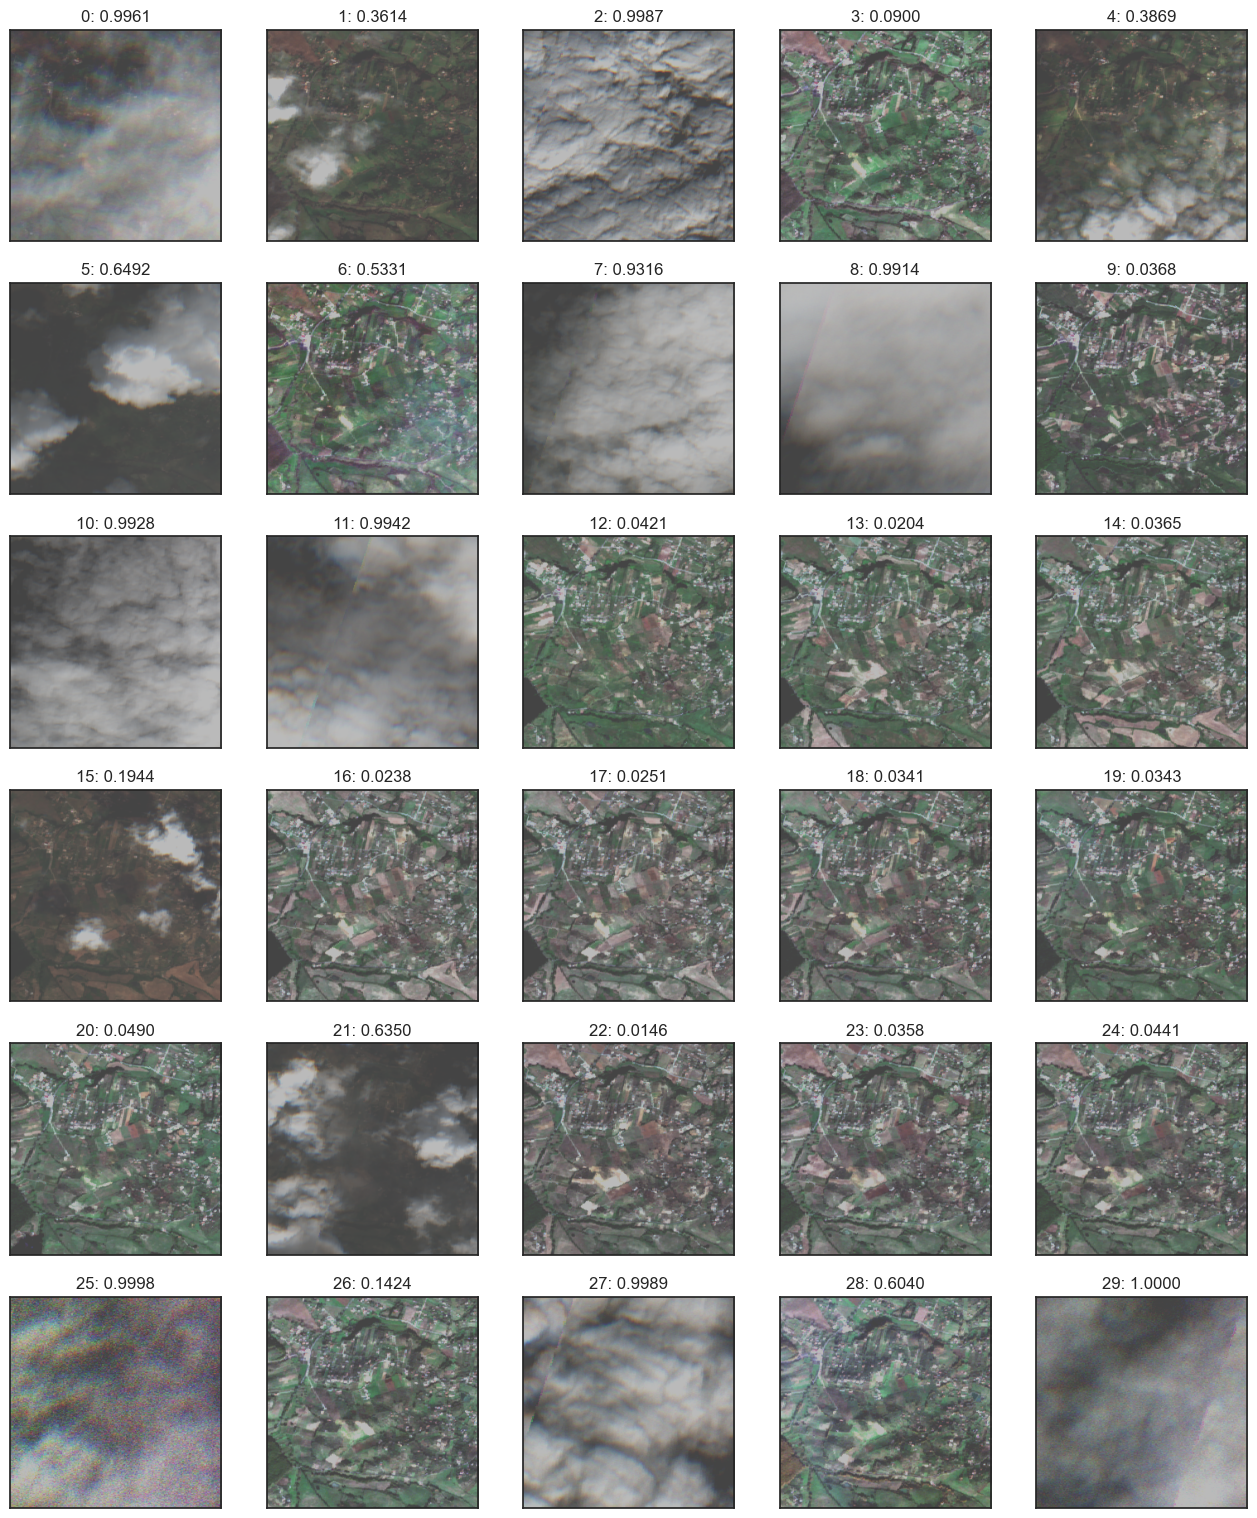

In [84]:
fig, axs = plt.subplots(6, 5, figsize=(16, 16 / 5 * 6))
axs = axs.reshape(-1)
for sample_img in Path('data/ts/sample_imgs/').iterdir():
    result = re.match(r"s2_(?P<roi>ROIs\d\d\d\d)_(?P<scene>\d+)_ImgNo_(?P<time_interval>\d+)_\d+-\d+-\d+_patch_(?P<patch>\d+)", sample_img.name)
    roi, scene, time_interval, patch = result.groups()
    axs[int(time_interval)].imshow(get_tci(rio.open(sample_img)))
    axs[int(time_interval)].get_xaxis().set_visible(False)
    axs[int(time_interval)].get_yaxis().set_visible(False)
    cp = patch_df[patch_df.time_interval == int(time_interval)].iloc[0]['cloud_percentage']
    axs[int(time_interval)].set_title("{}: {:.4f}".format(time_interval, cp))

## Classification 

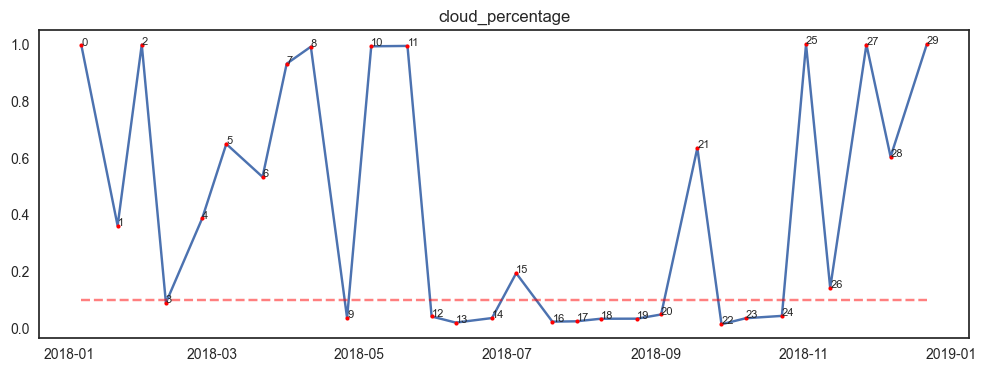

In [86]:
def show_feat_interval(df, feat, limit=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.plot(df['time'], df[feat])
    ax.plot(df['time'], df[feat], 'ro', markersize=3)
    for i, row in df.iterrows():
        ax.text(row['time'], row[feat], row['time_interval'], fontsize=8)
    if limit:
        ax.plot(df['time'].iloc[[0, -1]], [limit, limit], '--r', alpha=0.5)
    ax.set_title(feat)

fig, ax = plt.subplots(1,1, figsize=(12, 4))
show_feat_interval(patch_df, 'cloud_percentage', limit=0.1, ax=ax)

### Show bands

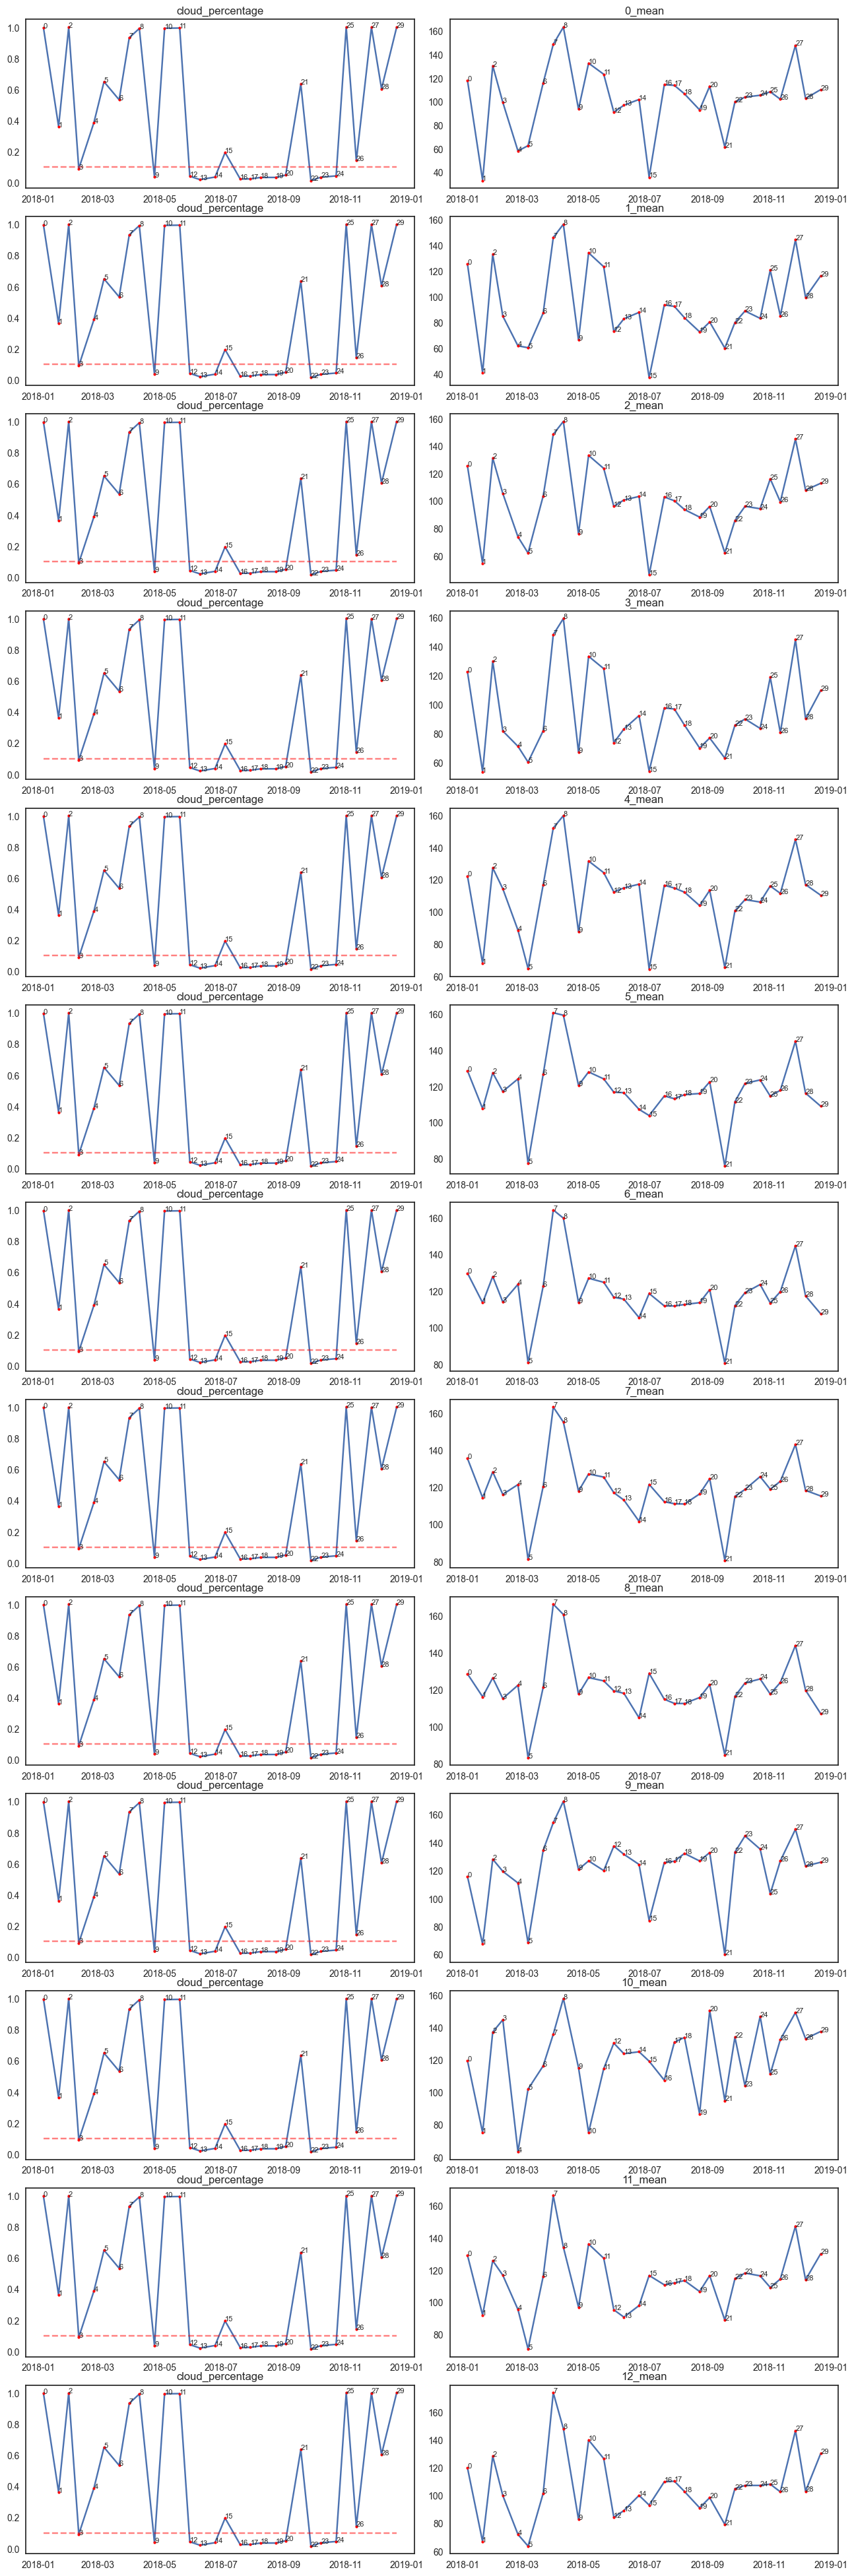

In [89]:
BAND_FEATS = [f"{i}_mean" for i in range(13)]
fig, axs = plt.subplots(13, 2, figsize=(13, 3*13))
fig.tight_layout(h_pad=1)
for index, (c_ax, f_ax) in zip(BAND_FEATS, axs):
    show_feat_interval(patch_df, 'cloud_percentage', limit=0.1, ax=c_ax)
    show_feat_interval(patch_df, index, ax=f_ax)

### Show indexs

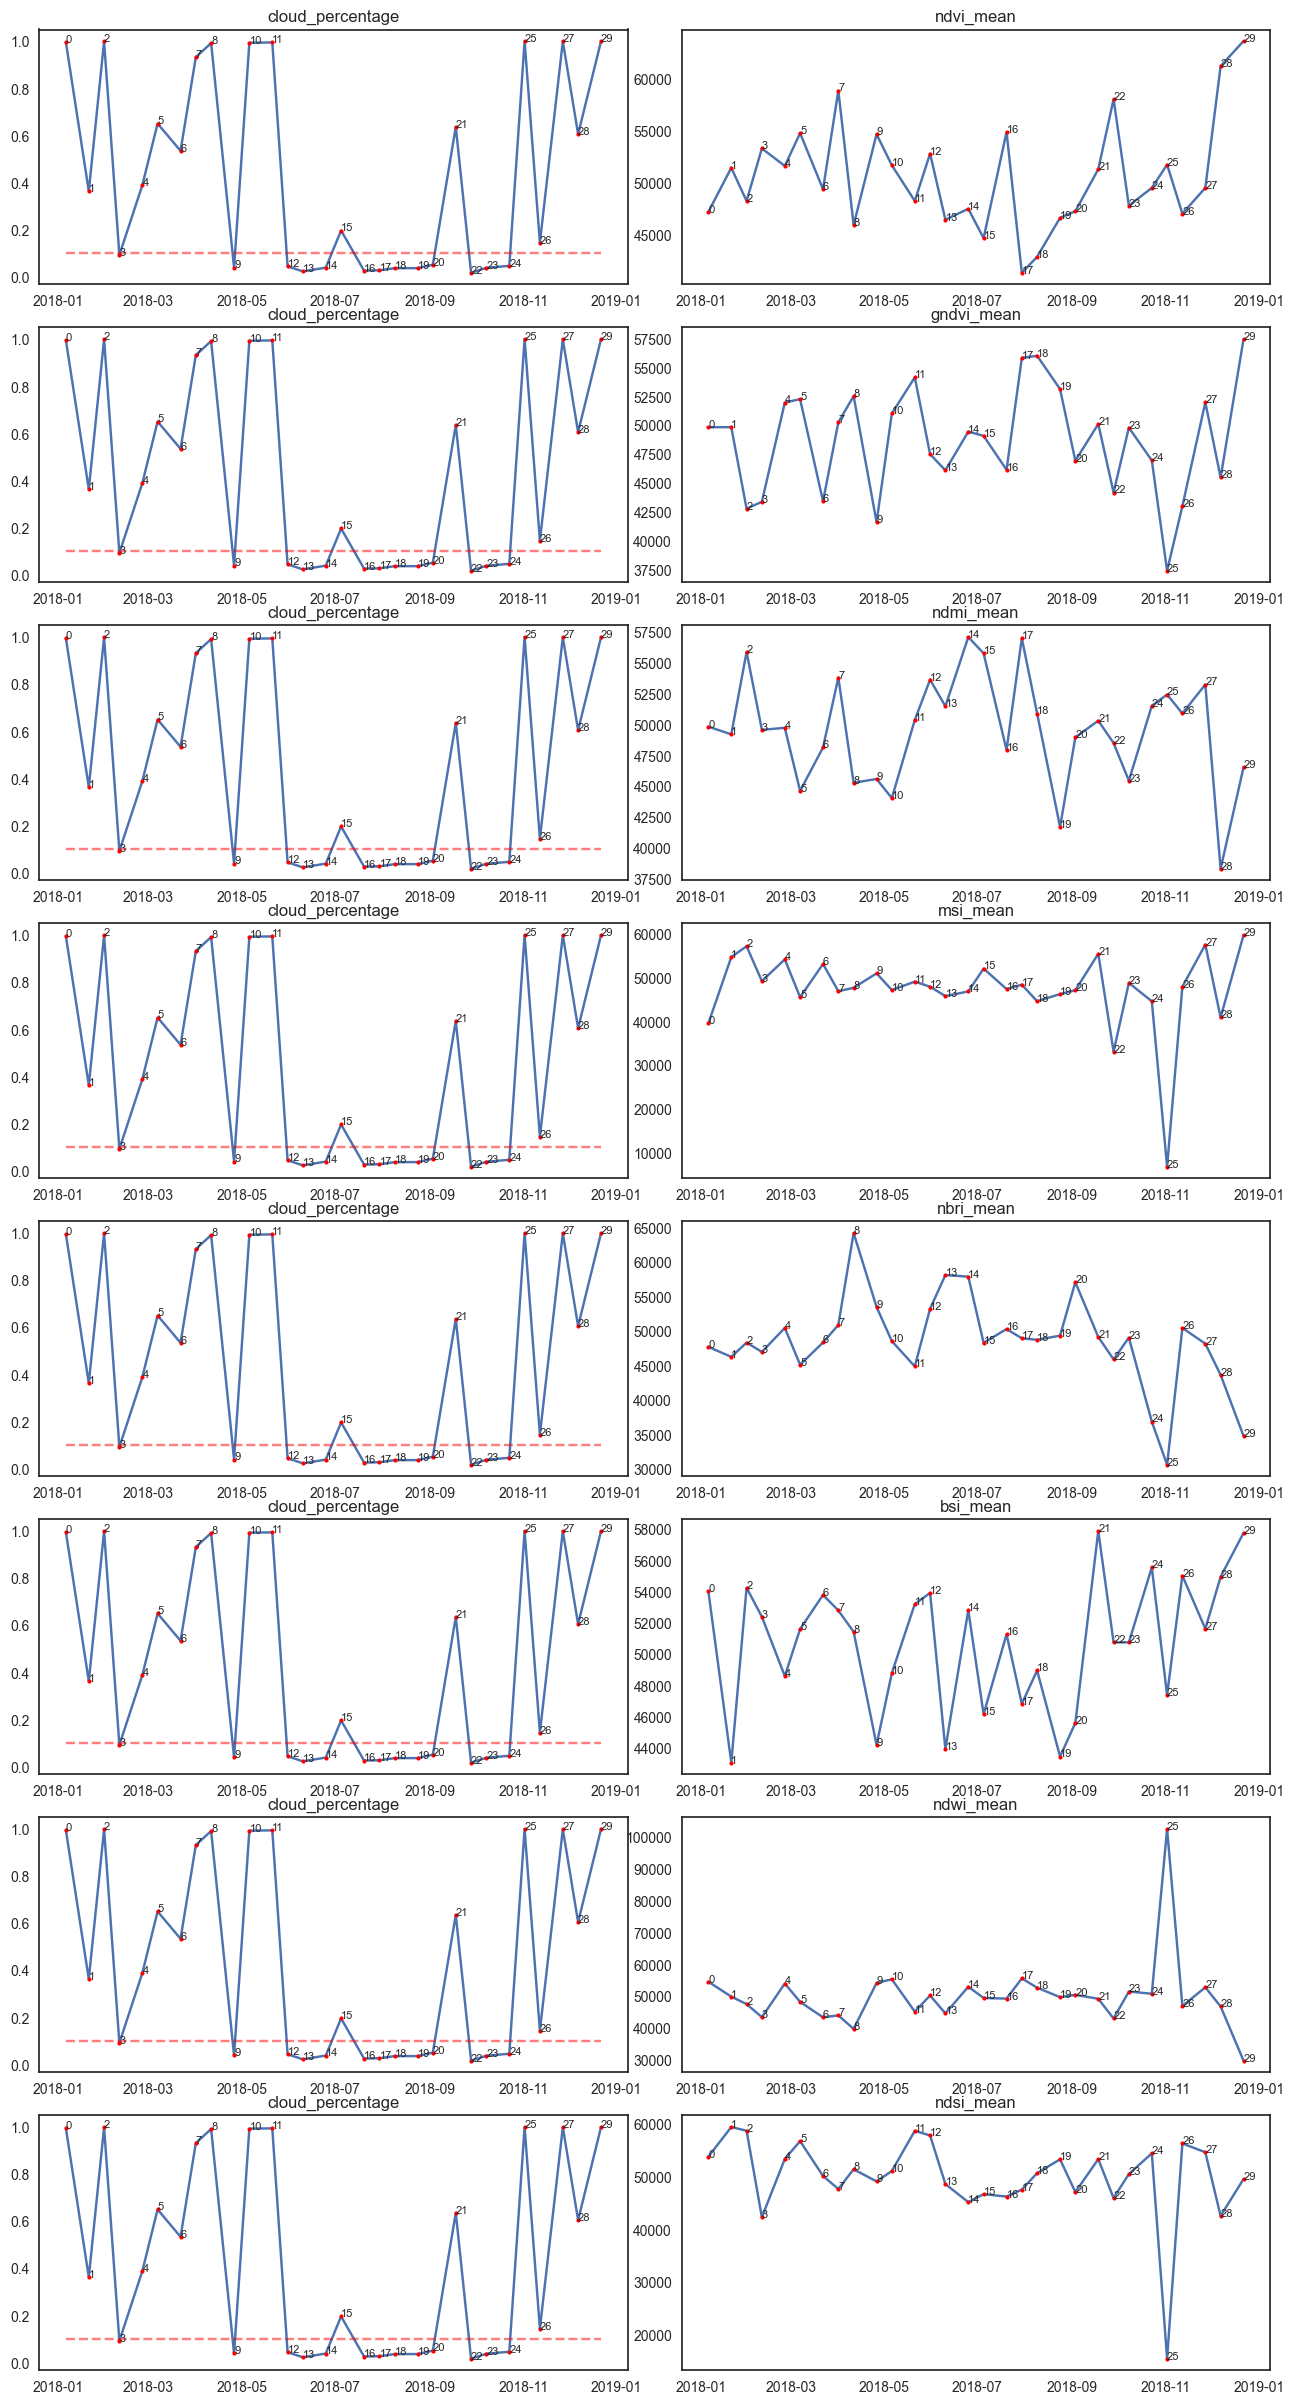

In [93]:
INDEXS = ["ndvi", "gndvi", "ndmi", "msi", "nbri", "bsi", "ndwi", "ndsi"]
INDEX_FEATS = [f"{index}_mean" for index in INDEXS]
fig, axs = plt.subplots(len(INDEXS), 2, figsize=(13, 3*len(INDEXS)))
fig.tight_layout(h_pad=1)
for index, (c_ax, f_ax) in zip(INDEX_FEATS, axs):
    show_feat_interval(patch_df, 'cloud_percentage', limit=0.1, ax=c_ax)
    show_feat_interval(patch_df, index, ax=f_ax)

## Outlier detection

- IQR
- Standard deviation
- Z-score

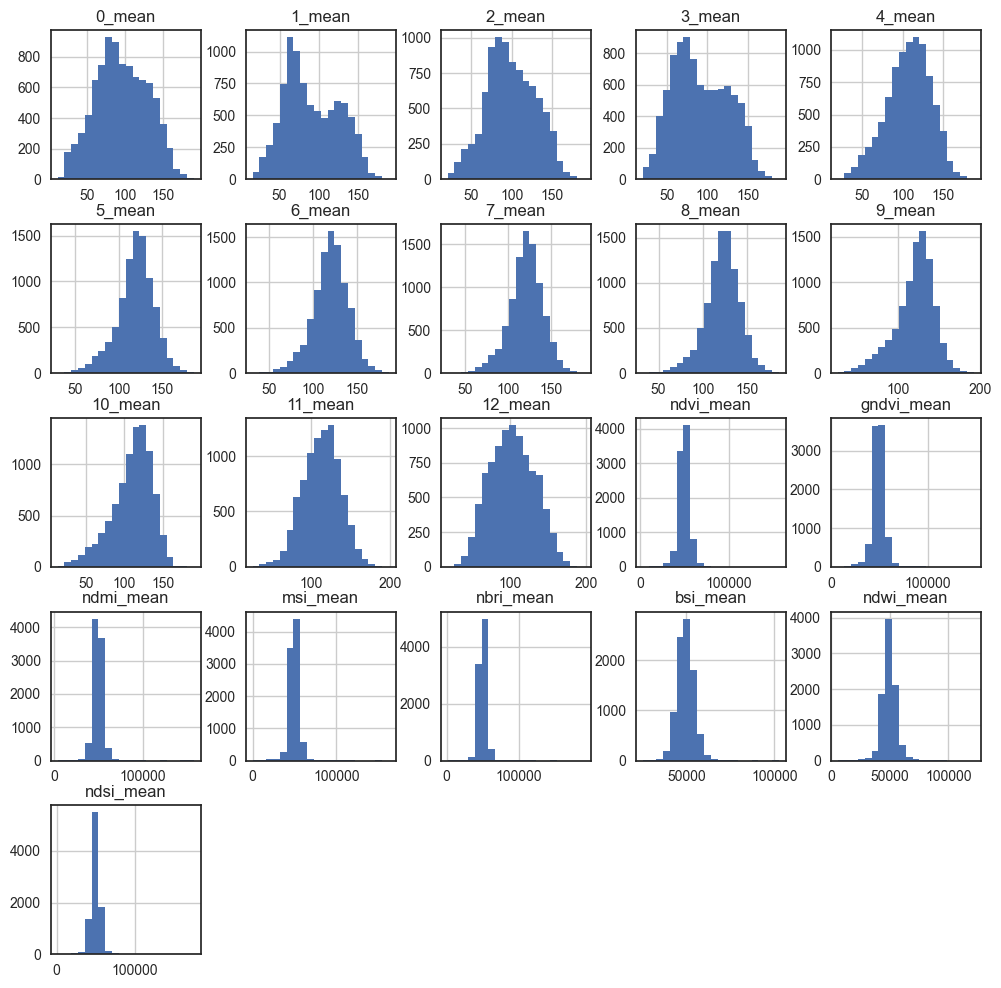

In [151]:
OUTLIER_FEATS = BAND_FEATS + INDEX_FEATS
df[OUTLIER_FEATS].hist(bins=20, figsize=(12, 12))
pass

### IQR

In [152]:
def iqr_outlier_detection(df):
    q1 = df[INDEX_FEATS].quantile(0.25)
    q3 = df[INDEX_FEATS].quantile(0.75)
    iqr = q3 - q1
    outliers = (df[((df[INDEX_FEATS] < (q1 - 1.5 * iqr)).sum(axis=1) > len(INDEX_FEATS) // 2) & ((df[INDEX_FEATS] < (q3 + 1.5 * iqr)).sum(axis=1) > len(INDEX_FEATS) // 2)])
    return outliers
    
iqr_outlier_detection(df)

0_traditional_contrast  0_michelson_contrast  0_rms_contrast  \
12                 0.350110                   1.0       55.990832   
18                 0.671372                   1.0       69.667688   
21                 0.334664                   1.0       57.801563   
38                 0.615665                   1.0       70.481622   
39                 0.416668                   1.0       66.764802   
42                 0.527553                   1.0       67.722415   
68                 0.364439                   1.0       55.687853   
69                 0.408197                   1.0       61.786962   
75                 0.409574                   1.0       60.011241   
77                 0.433766                   1.0       68.698786   
83                 0.524899                   1.0       65.349009   
85                 0.468809                   1.0       66.942461   
98                 0.438579                   1.0       63.063247   
118                0.640082                   1.0       63.564650   
120                0.494609                   1.0       64.948497   
134                0.479656                   1.0       58.473375   
137                0.492830                   1.0       66.775534   
140                0.608052                   1.0       71.060157   
142                0.623956                   1.0       70.135806   
145                0.413662                   1.0       61.208599   
181                0.702446                   1.0       76.211260   
183                0.642589                   1.0       68.525364   
191                0.438900                   1.0       63.822839   
202                0.730833                   1.0       77.029651   
209                0.558166                   1.0       63.289521   
230                0.356913                   1.0       56.889483   
231                0.547154                   1.0       68.722311   
233                0.545567                   1.0       67.941919   
238                0.541482                   1.0       66.264063   
247                0.654907                   1.0       64.516320   
278                0.462422                   1.0       61.991565   
288                0.569108                   1.0       60.359319   
293                0.385167                   1.0       57.121312   

     0_laplacian_blur      0_mean  0_median  0_p25  0_p75      0_std  \
12         174.224102  159.923340     166.0  129.0  202.0  55.990832   
18         139.387706  103.769150      92.0   47.0  155.0  69.667688   
21          55.516351  172.715012     191.0  145.0  211.0  57.801563   
38         155.722104  114.480484      99.0   60.0  173.0  70.481622   
39         235.846135  160.234940     174.0  123.0  209.0  66.764802   
42         193.404466  128.370789     134.0   69.0  183.0  67.722415   
68         291.046145  152.804184     163.0  127.0  189.0  55.687853   
69         100.600810  151.365662     163.0  120.0  198.0  61.786962   
75         438.118022  146.521011     153.0  105.0  193.0  60.011241   
77          74.877502  158.377411     179.0  117.0  213.0  68.698786   
83          87.537655  124.498184     123.0   77.0  177.0  65.349009   
85         351.321468  142.792465     153.0   89.0  196.0  66.942461   
98         230.329753  143.790070     145.0  103.0  192.0  63.063247   
118        155.841708   99.307022      87.0   54.0  131.0  63.564650   
120        154.179947  131.312775     130.0   81.0  184.0  64.948497   
134        318.665573  121.906815     120.0   80.0  160.0  58.473375   
137         64.641650  135.494156     138.0   85.0  186.0  66.775534   
140        139.489724  116.865250     108.0   56.0  171.0  71.060157   
142         64.518936  112.405106     111.0   50.0  167.0  70.135806   
145         90.128080  147.967590     156.0  114.0  192.0  61.208599   
181         56.891534  108.494125      92.0   44.0  173.0  76.211260   
183         63.697947  106.639465      95.0   47.0  155.0  68.525364   
19

### STD Deviation

In [153]:
def std_deviation_outlier_detection(df):
    mean = df[INDEX_FEATS].mean()
    std = df[INDEX_FEATS].std()
    outliers = (df[((df[INDEX_FEATS] < (mean - 3 * std)).sum(axis=1) > len(INDEX_FEATS) // 2) & ((df[INDEX_FEATS] < (mean + 3 * std)).sum(axis=1) > len(INDEX_FEATS) // 2)])
    return outliers
    
std_deviation_outlier_detection(patch_df)

Empty DataFrame
Columns: [0_traditional_contrast, 0_michelson_contrast, 0_rms_contrast, 0_laplacian_blur, 0_mean, 0_median, 0_p25, 0_p75, 0_std, 1_traditional_contrast, 1_michelson_contrast, 1_rms_contrast, 1_laplacian_blur, 1_mean, 1_median, 1_p25, 1_p75, 1_std, 2_traditional_contrast, 2_michelson_contrast, 2_rms_contrast, 2_laplacian_blur, 2_mean, 2_median, 2_p25, 2_p75, 2_std, 3_traditional_contrast, 3_michelson_contrast, 3_rms_contrast, 3_laplacian_blur, 3_mean, 3_median, 3_p25, 3_p75, 3_std, 4_traditional_contrast, 4_michelson_contrast, 4_rms_contrast, 4_laplacian_blur, 4_mean, 4_median, 4_p25, 4_p75, 4_std, 5_traditional_contrast, 5_michelson_contrast, 5_rms_contrast, 5_laplacian_blur, 5_mean, 5_median, 5_p25, 5_p75, 5_std, 6_traditional_contrast, 6_michelson_contrast, 6_rms_contrast, 6_laplacian_blur, 6_mean, 6_median, 6_p25, 6_p75, 6_std, 7_traditional_contrast, 7_michelson_contrast, 7_rms_contrast, 7_laplacian_blur, 7_mean, 7_median, 7_p25, 7_p75, 7_std, 8_traditional_contrast, 8_michelson_contrast, 8_rms_contrast, 8_laplacian_blur, 8_mean, 8_median, 8_p25, 8_p75, 8_std, 9_traditional_contrast, 9_michelson_contrast, 9_rms_contrast, 9_laplacian_blur, 9_mean, 9_median, 9_p25, 9_p75, 9_std, 10_traditional_contrast, 10_michelson_contrast, 10_rms_contrast, 10_laplacian_blur, 10_mean, 10_median, 10_p25, 10_p75, 10_std, 11_traditional_contrast, ...]
Index: []

[0 rows x 211 columns]

### Z-score 

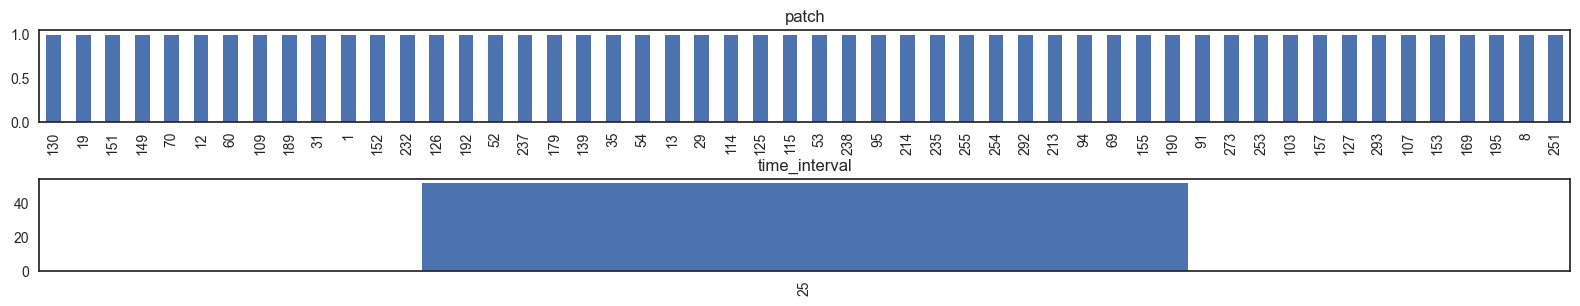

In [186]:
def z_score_outlier_detection(df):
    mean = df[INDEX_FEATS].mean()
    std = df[INDEX_FEATS].std()
    z_score = ((df[INDEX_FEATS] - mean) / std).abs()
    outliers = df[((z_score > 3).sum(axis=1) > len(INDEX_FEATS) // 2)]
    return outliers

z_score_outliers = z_score_outlier_detection(df)
fig, axs = plt.subplots(2,1, figsize=(16, 3))
fig.tight_layout(h_pad=2)
for feat_plot, row_ax in zip(['patch', 'time_interval'], axs):
    z_score_outliers[feat_plot].value_counts().plot(kind='bar', ax=row_ax)
    row_ax.set_title(feat_plot)

In [ ]:
## 